In [21]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Mortality_31d"] == "no"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

keys = ["Days", "Changes", "Atbs"]
times = ["Total", "Pre", "Post"]
groups = {"Amikacin"    : "Aminoglicosidos",
          "Gentamicin"  : "Aminoglicosidos",
          "Tigecycline" : "Tigecycline",
          "Colistin"    : "Polimixinas",
          "Polymyxin"   : "Polimixinas",
          "Meropenem"   : "Carba",
          "Ertapenem"   : "Carba",
          "Caz-avi"     : "Caz-avi"}

result = {key : {time : {group : [] for group in groups.values()} for time in times} for key in keys}

count = 0

for patient in patients:

    allaAtbs = [element for step in patient.translateTreatmentLine(only = "active",
                                                                 condensed = True,
                                                                 start = patient.bloodculture,
                                                                 days = False) for element in step if element != "None"]


    if "Caz-avi" in allaAtbs: count += 1

    for atb in groups:
        if atb in allaAtbs:

            # Days
            dayTreatment = patient.translateTreatmentLine(only = "active",
                                                          condensed = False,
                                                          start = patient.bloodculture,
                                                          days = False)
            for index, day in enumerate(dayTreatment):

                if atb in day:
                    result["Days"]["Total"][groups[atb]].append(len(dayTreatment))
                    result["Days"]["Pre"][groups[atb]].append(index)
                    result["Days"]["Post"][groups[atb]].append(len(dayTreatment) - index - 1)
                    break

            # Changes
            changeTreatment = patient.translateTreatmentLine(mergeInactive = True,
                                                             condensed = True,
                                                             start = patient.bloodculture,
                                                             days = False)
            for index, step in enumerate(changeTreatment):

                if atb in step:
                    result["Changes"]["Total"][groups[atb]].append(len(changeTreatment))
                    result["Changes"]["Pre"][groups[atb]].append(index)
                    result["Changes"]["Post"][groups[atb]].append(len(changeTreatment) - index - 1)
                    break

            # Changes
            atbsTreatment = patient.translateTreatmentLine(condensed = True,
                                                           mergeInactive = False,
                                                           start = patient.bloodculture,
                                                           days = False)
            for index, step in enumerate(atbsTreatment):
                if f"{atb}_S" in step:

                    allAtbs = set([element for step in atbsTreatment for element in step if element != "None"])

                    result["Atbs"]["Total"][groups[atb]].append(len(allAtbs) - 1)

                    preAtbs = set([element for step in atbsTreatment[:index] for element in step if element != "None"])
                    if f"{atb}_s" in preAtbs: preAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Pre"][groups[atb]].append(len(preAtbs))

                    posAtbs = set([element for step in atbsTreatment[index + 1:] for element in step if element != "None"])
                    if f"{atb}_s" in posAtbs: posAtbs.remove(f"{atb}_s")

                    result["Atbs"]["Post"][groups[atb]].append(len(posAtbs))
                    break

import pandas as pd

template = {}

flag = True

for key, value in result.items():
    for time, value in value.items():
        aux = []

        names = []

        for group, values in value.items():
            aux += values
            names += [group] * len(values)

        if flag:
            template["group"] = names

        template[f"{key}_{time}"] = aux

data = pd.DataFrame(template)
data.to_excel("test.xlsx")

In [22]:
len(result["Days"]["Total"]["Caz-avi"])


41

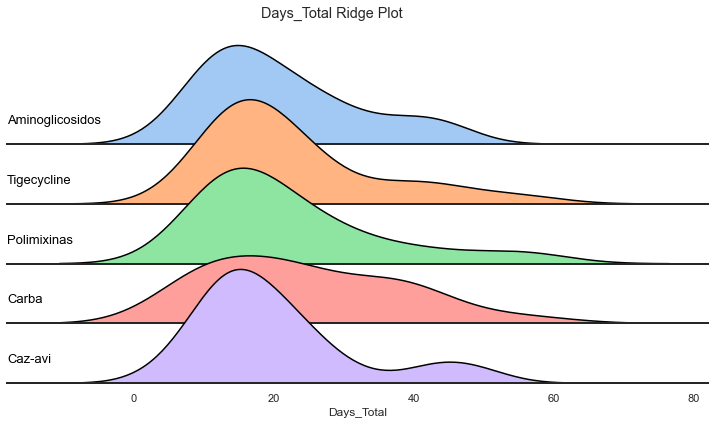

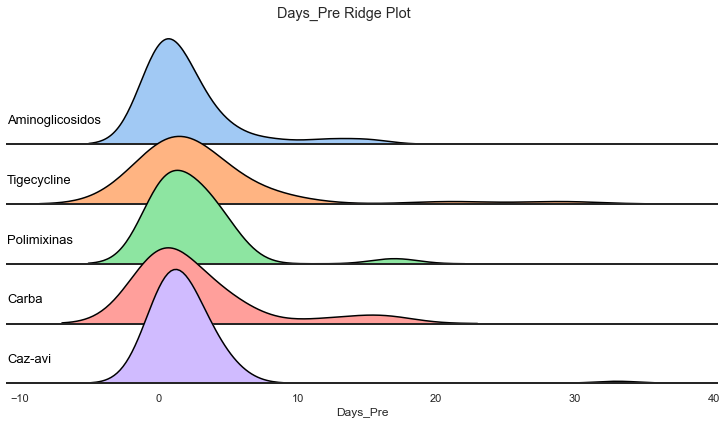

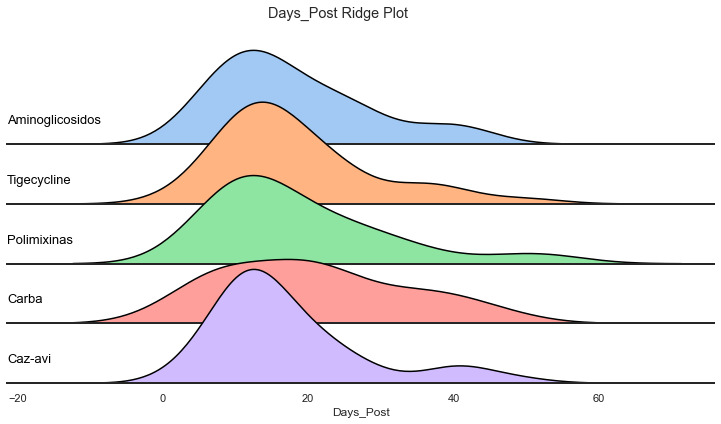

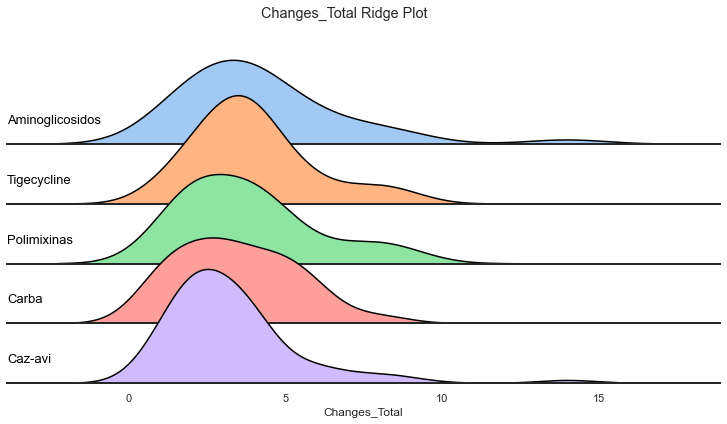

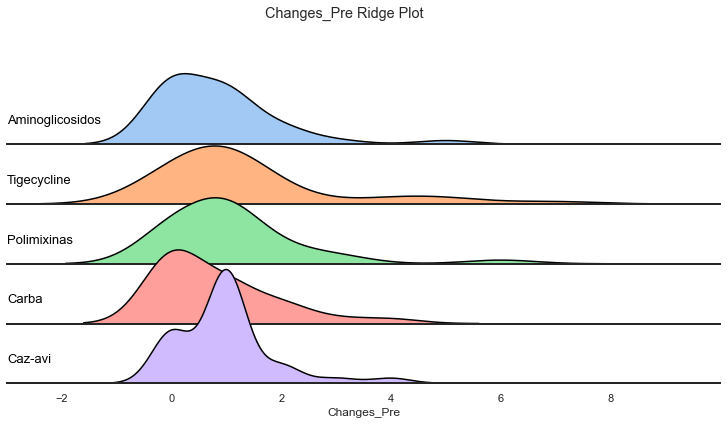

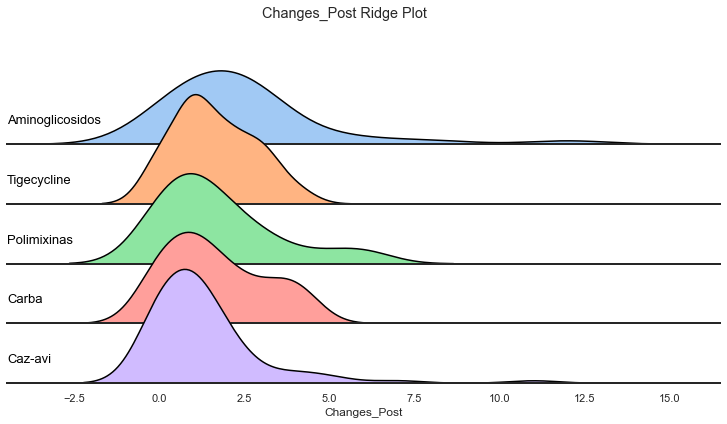

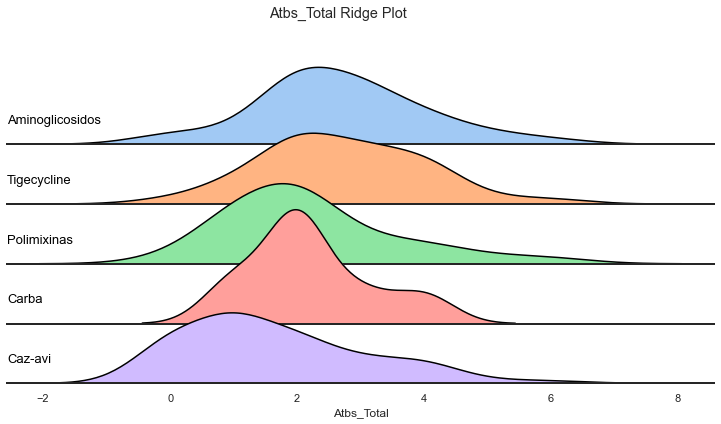

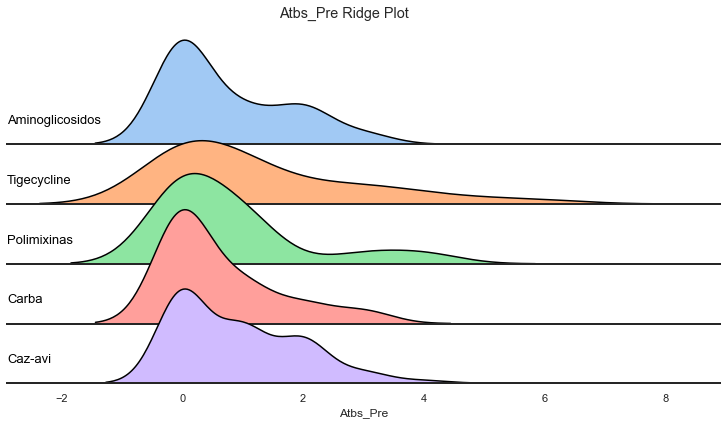

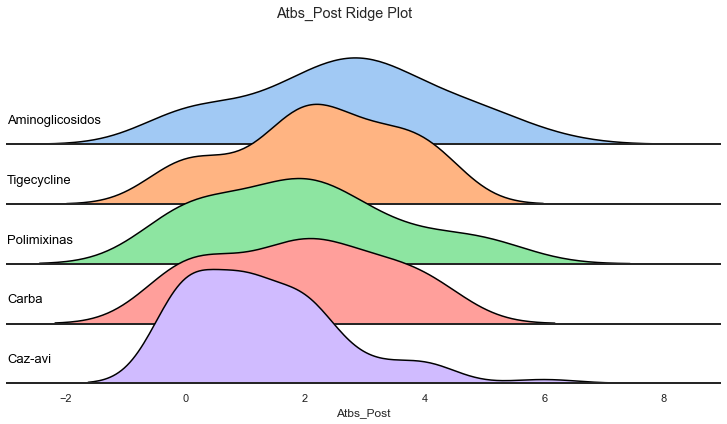

In [22]:
import pandas as pd
import numpy as np

from pystats_utils.plot import RidgePlot
from pystats_utils.test.value_comparison import MannWhitneyUTest

template = {"Variable"        : [],
            "All"             : [],
            "Aminoglicosidos" : [],
            "Polimixinas"     : [],
            "Tigecycline"     : [],
            "Carba"           : [],
            "Caz-avi"         : [],
            "Caz-avi vs. Aminoglicosidos" : [],
            "Caz-avi vs. Polimixinas"     : [],
            "Caz-avi vs. Tigecycline"     : [],
            "Caz-avi vs. Carba"     : []}

for column in data:

    if "group" != column:

        plot = RidgePlot(dataframe = data,
                         classVariable = "group",
                         targetVariable = column).run()

        plot.savefig(f"{column}.png", dpi = 300)


        result = MannWhitneyUTest(dataframe = data,
                                  classVariable = "group",
                                  targetVariable = column).run()

        template["Variable"].append(column)
        template["All"].append("{:.2f} ({:.2f} - {:.2f})".format(np.mean(data[column]),
                                                                 np.percentile(data[column], 25),
                                                                 np.percentile(data[column], 75)))

        for group in ["Aminoglicosidos", "Polimixinas", "Tigecycline", "Carba", "Caz-avi"]:

            template[group].append("{:.2f} ({:.2f} - {:.2f})".format(np.median(data[data["group"] == group][column]),
                                                                     np.percentile(data[data["group"] == group][column], 25),
                                                                     np.percentile(data[data["group"] == group][column], 75)))

        for pvalue in result.pvalue:

            if "Caz-avi" in pvalue:
                if "Aminoglicosidos" in pvalue: template["Caz-avi vs. Aminoglicosidos"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Polimixinas" in pvalue: template["Caz-avi vs. Polimixinas"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Tigecycline" in pvalue: template["Caz-avi vs. Tigecycline"].append("{:.3f}".format(result.pvalue[pvalue]))
                if "Carba" in pvalue: template["Caz-avi vs. Carba"].append("{:.3f}".format(result.pvalue[pvalue]))


result = pd.DataFrame(template)



In [23]:
result = result.rename(columns = {"All" : f"All (N={len(data)})",
                         "Aminoglicosidos" : f"Aminoglicosidos (N={len(data[data['group'] == 'Aminoglicosidos'])})",
                         "Polimixinas" : f"Polimixinas (N={len(data[data['group'] == 'Polimixinas'])})",
                         "Tigecycline" : f"Tigecycline (N={len(data[data['group'] == 'Tigecycline'])})",
                         "Carba"       : f"Carba (N={len(data[data['group'] == 'Carba'])})",
                         "Caz-avi" : f"Caz-avi (N={len(data[data['group'] == 'Caz-avi'])})"})

,Variable,All (N=204),Aminoglicosidos (N=35),Polimixinas (N=29),Tigecycline (N=36),Carba (N=29),Caz-avi (N=75),Caz-avi vs. Aminoglicosidos,Caz-avi vs. Polimixinas,Caz-avi vs. Tigecycline,Caz-avi vs. Carba
0,Days_Total,21.68 (13.00 - 26.00),17.00 (13.00 - 27.00),17.00 (13.00 - 27.00),18.00 (14.75 - 26.00),22.00 (14.00 - 35.00),17.00 (12.00 - 24.00),0.665,0.504,0.263,0.175
1,Days_Pre,2.43 (0.00 - 3.00),1.00 (0.00 - 2.00),2.00 (0.00 - 3.00),2.00 (0.00 - 3.00),0.00 (0.00 - 4.00),1.00 (0.00 - 2.00),0.385,0.419,0.333,0.546
2,Days_Post,18.25 (10.00 - 23.00),14.00 (11.00 - 24.50),14.00 (10.00 - 26.00),15.00 (11.75 - 23.00),19.00 (10.00 - 27.00),14.00 (10.00 - 21.00),0.664,0.658,0.489,0.218
3,Changes_Total,3.68 (2.00 - 4.00),4.00 (2.50 - 5.00),4.00 (2.00 - 5.00),4.00 (3.00 - 5.00),3.00 (2.00 - 5.00),3.00 (2.00 - 4.00),0.023,0.164,0.018,0.453
4,Changes_Pre,1.00 (0.00 - 1.00),1.00 (0.00 - 1.00),1.00 (0.00 - 1.00),1.00 (0.00 - 1.00),0.00 (0.00 - 1.00),1.00 (0.00 - 1.00),0.182,0.926,0.570,0.142
5,Changes_Post,1.67 (1.00 - 2.00),2.00 (1.00 - 3.00),1.00 (1.00 - 2.00),1.00 (1.00 - 2.25),1.00 (1.00 - 3.00),1.00 (0.00 - 2.00),0.001,0.185,0.037,0.139
6,Atbs_Total,2.17 (1.00 - 3.00),3.00 (2.00 - 3.00),2.00 (1.00 - 3.00),3.00 (2.00 - 4.00),2.00 (2.00 - 3.00),1.00 (1.00 - 2.00),0.000,0.038,0.000,0.011
7,Atbs_Pre,0.89 (0.00 - 1.00),0.00 (0.00 - 1.50),0.00 (0.00 - 1.00),1.00 (0.00 - 2.00),0.00 (0.00 - 1.00),1.00 (0.00 - 2.00),0.368,0.326,0.545,0.142
8,Atbs_Post,1.88 (1.00 - 3.00),3.00 (2.00 - 4.00),2.00 (1.00 - 3.00),2.00 (1.75 - 3.00),2.00 (1.00 - 3.00),1.00 (0.00 - 2.00),0.000,0.044,0.001,0.041


In [24]:
result.to_excel("treatment_comparation.xlsx")

In [14]:
extendendDataAux.to_excel("test.xlsx")

NameError: name 'extendendDataAux' is not defined

In [ ]:
import pandas as pd

dataframe = pd.read_excel("./test/database/database.xlsx")
workDataframe = dataframe[dataframe["Cohort_Treatment"] == "yes"]

from pystats_utils.test.multivariant import CoxPhRegression

targetVariable = ["Gender",
                   "Age",
                   "ICS_SOT_score",
                   "Cohort_Cazavi",
                   "ps_cvsb"]

result = CoxPhRegression(dataframe = workDataframe,
                         eventVariable = "Mortality_31d",
                         timeVariable = "Time2death_31d",
                         targetVariable = targetVariable).run()

result.params.to_excel("tabla_4a_params_raw.xlsx")
result.summary.to_excel("tabla_4a_metrics_raw.xlsx")
result.params

In [1]:
#import some libraries
import numpy as np
import pandas as pd
from lifelines import*
import seaborn as sns
import matplotlib.pyplot as plt
x=[0]
y=[1]

df=pd.DataFrame({'Treatment': 21*x+21*y,'t':[1,1,2,2,3,4,4,5,5,8,8,8,8,11,11,12,12,15,17,22,23,6,6                                                ,6,6,7,9,10,10,11,13,16,17,19,20,22,23,25,32,32,34,35],
                 'status':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0]})

Statistics :0.9999999990134123, p_value:1.7711333786113465e-81
The distribution differs from normal
Statistics :0.9999999990134123, p_value:1.700820017329315e-108
The distribution differs from normal
The group  who received treatment and censored 
 Skewness:0.062108749845546554 Kurtosis:-1.477444808690349
The group  who received treatment and censored 
 Skewness:0.6158300355699876 Kurtosis:-1.1597419016159343


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.79 <0.005     14.55

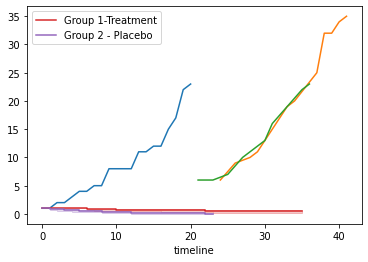

In [7]:
mask=(df['Treatment']==1) & (df['status']==0)
mask1=(df['Treatment']==1) & (df['status']==1)
plt.figure()
df.groupby(['Treatment','status'])['t'].plot()

#Normality tests
from scipy import stats
def normal(col):
    statistic,p_value=stats.kstest(col,'norm')
    print('Statistics :{0}, p_value:{1}'.format(statistic,p_value))
    if p_value < 0.05:
        return  print('The distribution differs from normal')
    else:
        return  print('The distribution is normal')
normal(df[mask1]['t'])
normal(df[mask]['t'])

def skew_kurt(col):
    return print('The group  who received treatment and censored \n Skewness:{0} Kurtosis:{1}'.format(stats.skew(col),stats.kurtosis(col)))

skew_kurt(df[mask]['t'])
skew_kurt(df[mask1]['t'])

#KM curve
from lifelines import KaplanMeierFitter
group1=df[df['Treatment']==1]
group2=df[df['Treatment']==0]
T=group1['t']
E=group1['status']
T1=group2['t']
E1=group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1-Treatment").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Placebo").plot(ax=ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

In [36]:
from pystats_utils.utils.patient import Patient

import pandas as pd

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Cohort_Cazavi"] == "yes"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))


In [53]:
import numpy as np

aux = []
for patient in patients:

    treatment = patient.translateTreatmentLine(condensed = False,
                                               mergeInactive = False,
                                               start = patient.bloodculture,
                                               days = False)

    count = 0
    for day in treatment:
        if "Caz-avi_S" in day:
            break
        else: #count += 1
            if "None" in day: pass
            else: count += 1

    aux.append(count)
    
from collections import defaultdict
a = defaultdict(int)
for i in aux:
    a[i] += 1

f"{np.mean(aux)} ({np.percentile(aux, 25)} - {np.percentile(aux, 75)})"
print(a)

defaultdict(<class 'int'>, {0: 37, 1: 19, 5: 3, 2: 14, 4: 5, 3: 5})


In [19]:
from pystats_utils.utils.patient import Patient

import pandas as pd

import numpy as np

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Cohort_Cazavi"] == "yes"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))
    
    
total = []
pre = []
for patient in patients:
    treatment = patient.translateTreatmentLine(condensed = False,
                                               mergeInactive = False,
                                               start = patient.bloodculture,
                                               days = False)
    
    total.append(len(treatment))
    pre.append([i for i, x in enumerate(a) if x != "a"][0])
    
np.median(total)

17.0

In [10]:
a = ["a", "a", "c", "a"]
[i for i, x in enumerate(a) if x != "a"][0]

2